In [1]:
! pip install einops
! pip install transformers==4.50.0


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 2.7 MB/s  0:00:036m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 2.4 MB/s  0:00:01m eta 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:━━━━━━━━━━━━━ 0/2 [tokenizers]
      Successfully uninstalled tokenizers-0.20.3 0/2 [tokenizers]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/2 [tokenizers]  WARNING: Failed to remove contents in a temporary directory '/auto/master14/yehyouming/miniconda3/lib/python3.13/site-packages/~okenizers'.
  You can safely remove it manually.
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0.dev0━━━━━━━━━ 1/2 [transformers]
    Uninstalling transformers-4.47.0.dev0:m━━━━━━━━━━━━━━━━━━━ 1/2 [transformers]
      Successfully uninstalled transformers-4.47.0.dev0

/home/master/14/yehyouming/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [17:09<00:00, 514.50s/it]


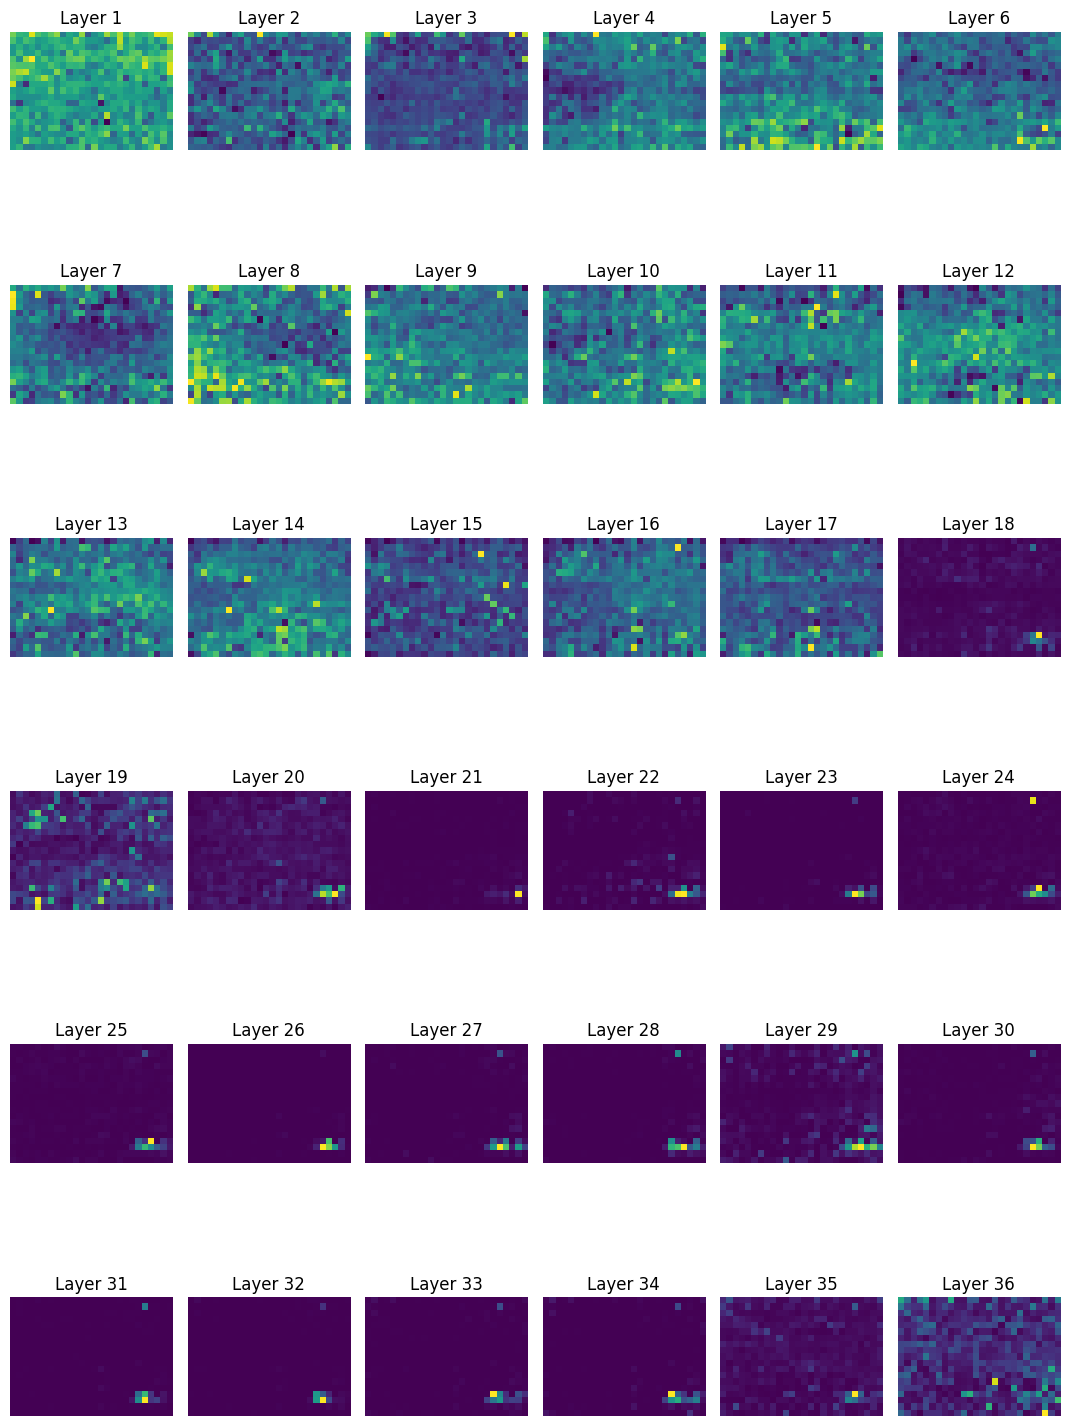

In [2]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
import matplotlib.pyplot as plt
from qwen_vl_utils import process_vision_info
import math 

def calculate_plt_size(attention_layer_num):    
    num_layers = attention_layer_num
    cols = math.ceil(math.sqrt(num_layers))  
    rows = math.ceil(num_layers / cols)     
    return rows, cols

device = 'cuda'
model_path = 'Qwen/Qwen2.5-VL-3B-Instruct'

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
                model_path,
                torch_dtype=torch.bfloat16,
                attn_implementation="eager",
            ).eval().to(device)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True, padding_side='left', use_fast=True)

image_path = './images/demo1.png'
question = 'what is the date of the photo?'

messages_query = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path, "max_pixels": 512*28*28},
            {"type": "text", "text": f"{question} Answer the question using a single word or phrase."},
        ],
    }
]

image_inputs, _ = process_vision_info(messages_query)

text_query = processor.apply_chat_template(
    messages_query,
    tokenize=False,
    add_generation_prompt=True
)

inputs = processor(
    text=[text_query],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
).to(device)

messages_general = [
    {
        "role": "user",
        "content": [
            {"type": "image","image": image_path,"max_pixels": 512*28*28},
            {"type": "text", "text": "Write a general description of the image. Answer the question using a single word or phrase."},
        ],
    }
]

text_general = processor.apply_chat_template(
    messages_general,
    tokenize=False,
    add_generation_prompt=True
)

general_inputs = processor(
    text=[text_general],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
).to(device)

image_inputs_aux = processor.image_processor(images=image_inputs)
output_shape = image_inputs_aux["image_grid_thw"].numpy().squeeze(0)[1:]/2
output_shape = output_shape.astype(int)

with torch.no_grad():
    vision_start_token_id = processor.tokenizer.convert_tokens_to_ids('<|vision_start|>')
    vision_end_token_id = processor.tokenizer.convert_tokens_to_ids('<|vision_end|>')
    pos = inputs['input_ids'].tolist()[0].index(vision_start_token_id) + 1
    pos_end = inputs['input_ids'].tolist()[0].index(vision_end_token_id)

    output = model(**inputs, output_attentions=True)
    general_output = model(**general_inputs, output_attentions=True)
    rows, cols = calculate_plt_size(len(output.attentions))
    fig, axes = plt.subplots(rows, cols, figsize=(10.8, 16))
    for i, ax in enumerate(axes.flatten()):
        if i < len(output.attentions): 
            att = output.attentions[i][0, :, -1, pos:pos_end].mean(dim=0)
            att = att.to(torch.float32).detach().cpu().numpy()

            general_att = general_output.attentions[i][0, :, -1, pos:pos_end].mean(dim=0)
            general_att = general_att.to(torch.float32).detach().cpu().numpy()

            att = att / general_att

            ax.imshow(att.reshape(output_shape), cmap="viridis", interpolation="nearest")
            ax.set_title(f"Layer {i+1}")
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()    
    plt.show()    